In [1]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import quad
from scipy.interpolate import interp1d

from cosmology import *
from pbh import *
from ucmh import *

def mantissa_exp(x):
    exp = np.floor(np.log10(x))
    return x/10**exp, exp

def log_levels(data, n=10):
    data = [d for d in data.flatten() if d != 0 and not np.isnan(d)]
    return np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), n)

def sci_contours(x, y, vals, ax, levels=None):
    """Creates density contour plot with labels using scientific notation.
    """
    if levels is None:
        levels = log_levels(vals)

    cs = ax.contour(x, y, vals, levels=levels, norm=LogNorm())
    clabels = {level: (r"%.2f" % (level / 10.**np.floor(np.log10(level)))) +
               (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
               for level in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)

Thoughts
* Seems like PBH abundance will always be much higher than the UCMH abundance. This is probably since UCMHs form from CDM-only whereas PBHs form from radiation (easy to test). Does this mean we can rule out the formation of UCMHs in models that modify the power spectrum in simple ways since they would come along with a large number of very heavy PBHs?

In [2]:
# Consider spike enhancements to primordial power spectrum
def beta_pbh(a):
    return pr_pbh_collapse(sigma=sigma_spike(r_hor_phys(a), As, ks))

def beta_ucmh(a):
    return pr_ucmh_collapse(sigma=sigma_spike(r_hor_phys(a), As, ks))

a_ucmh_end = a_of_z(30)  # time at which to shut off UCMH accretion

In [3]:
def get_f(ms, df_dms):
    """Computes total abundance relative to Omega_{CDM,0}.
    
    Notes
    -----
    Assumes df/dm is negligible when it's less than 100 times the max value.
    """
    # Get indices in window around large df_dms
    idxs = np.where(df_dms > 1e-2*df_dms.max())[0]
    padding = 5
    idxs = np.concatenate((idxs[:padding] - padding, idxs, idxs[-padding:] + padding))
    
    interp = interp1d(ms[idxs], df_dms[idxs])
    integral, err = quad(interp, *ms[idxs[[0, -1]]], epsrel=1e-4, epsabs=1e-100)
    
    return integral

## Exploratory plots

In [194]:
# # Scenario 1
# a_spike = a_of_z(1e12)  # gives M_sun PBHs
# ks = 1/r_hor_phys(a_spike)
# As = 1.5
# a_is = np.logspace(-13, -11.5, 500)

# # Scenario 2
# a_spike = a_of_z(3e9)  # gives 5 M_sun PBHs
# ks = 1/r_hor_phys(a_spike)
# As = 1.
# a_is = np.logspace(-10.5, -9, 500)

a_spike = 1e-9  # gives 5 M_sun PBHs
ks = 1/r_hor_phys(a_spike)
As = 1.
a_is = np.logspace(-10, -8, 500)

In [195]:
# PBH abundance
m_pbhs, _, df_dm_pbhs = mass_fn_pbh_simple(a_is, beta_pbh)
f_pbh = get_f(m_pbhs, df_dm_pbhs)

/Users/acoogan/Dropbox/Physics/Black holes/pyverse/pbh.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return erfc(delta_c / (np.sqrt(2) * sigma))
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/pbh.py:35: RuntimeWarning: overflow encountered in true_divide
  return erfc(delta_c / (np.sqrt(2) * sigma))


In [196]:
# UCMH abundance
Omega_cdm = (1 - f_pbh) * Omega_cdm_0
m_ucmh_is, m_ucmhs, df_dm_ucmhs = mass_fn_ucmh_simple(a_is, beta_ucmh, Omega_cdm_bc=Omega_cdm)
f_ucmh = get_f(m_ucmhs, df_dm_ucmhs)

/Users/acoogan/Dropbox/Physics/Black holes/pyverse/ucmh.py:31: RuntimeWarning: divide by zero encountered in true_divide
  return (erfc(delta_min / (np.sqrt(2) * sigma)) -
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/ucmh.py:31: RuntimeWarning: overflow encountered in true_divide
  return (erfc(delta_min / (np.sqrt(2) * sigma)) -
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/ucmh.py:32: RuntimeWarning: divide by zero encountered in true_divide
  erfc(delta_max / (np.sqrt(2) * sigma)))
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/ucmh.py:32: RuntimeWarning: overflow encountered in true_divide
  erfc(delta_max / (np.sqrt(2) * sigma)))


Text(0, 0.5, '$\\frac{df}{dm}$ ($M_\\odot^{-1}$)')

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


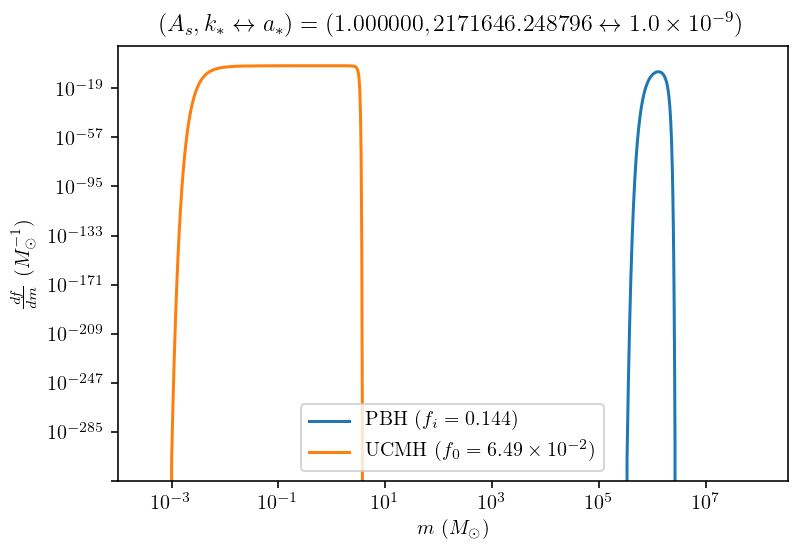

In [197]:
# Plotting
plt.loglog(m_pbhs, df_dm_pbhs,
           label=r"PBH ($f_i=%.3f$)" % f_pbh)
plt.loglog(m_ucmhs, df_dm_ucmhs,
           label=r"UCMH ($f_0 = %.2f \times 10^{%i}$)" % mantissa_exp(f_ucmh))

# Formatting
plt.legend()
plt.title(r"$(A_s, k_* \leftrightarrow a_*) = (%f, %f \leftrightarrow %.1f \times 10^{%i})$" %
          (As, ks, *mantissa_exp(a_spike)))
plt.xlabel(r"$m$ ($M_\odot$)")
plt.ylabel(r"$\frac{df}{dm}$ ($M_\odot^{-1}$)")

# # Scenario 1
# plt.xlim(1e-12, 1e2)
# plt.ylim(1e-8, 1e0)
# plt.savefig("../figures/f_m_As_1.5_as_1e-12.pdf")

# # Scenario 2
# plt.xlim(1e-5, 1e6)
# plt.ylim(1e-8, 1e0)
# plt.savefig("../figures/f_m_As_1_as_3e-10.pdf")

## $f_{{\rm PBH},i} / f_{\rm UCMH}$, $m_{{\rm PBH},i} / m_{\rm UCMH}$

Consider spikes between EWPT ($z_{\rm EWPT} \sim 10^{15}$) and a bit before BBN ($z_{\rm BBN} \sim 4\times 10^8$). Recall that solar-mass PBHs form from a spike at $a = 10^{-12} \leftrightarrow z = 10^{12}$.

In [221]:
a_spikes = np.logspace(-15, -9, 40)
kss = 1 / r_hor_phys(a_spikes)
Ass = np.logspace(np.log10(0.5), np.log10(3), 40)
As_mg, ks_mg = np.meshgrid(Ass, kss)

a_is = np.logspace(-16, -8, 500)

In [222]:
def get_fs(As_mg, ks_mg, a_vals):
    def _helper(As, ks):
        beta_pbh = lambda a: pr_pbh_collapse(sigma=sigma_spike(r_hor_phys(a), As, ks))
        beta_ucmh = lambda a: pr_ucmh_collapse(sigma=sigma_spike(r_hor_phys(a), As, ks))

        # PBH abundance
        m_pbhs, _, df_dm_pbhs = mass_fn_pbh_simple(a_is, beta_pbh)
        f_pbh = get_f(m_pbhs, df_dm_pbhs)
        # Mode of mass distribution
        m_pbh_mean = m_pbhs[np.argmax(df_dm_pbhs)]

        if f_pbh < 1:
            # Initial differential UCMH abundance
            Omega_cdm = (1 - f_pbh) * Omega_cdm_0
            _, m_ucmhs, df_dm_ucmhs = mass_fn_ucmh_simple(
                a_is, beta_ucmh, Omega_cdm_bc=Omega_cdm)
            # Total abundance
            f_ucmh = get_f(m_ucmhs, df_dm_ucmhs)    
            # Mode of mass distribution
            m_ucmh_mean = m_ucmhs[np.argmax(df_dm_ucmhs)]
        else:
            m_ucmh_mean, f_ucmh = 0., 0.

        return f_pbh, f_ucmh, m_pbh_mean, m_ucmh_mean
    
    return np.vectorize(_helper)(As_mg, ks_mg)

In [223]:
f_pbhs, f_ucmhs, m_pbh_means, m_ucmh_means = get_fs(As_mg, ks_mg, a_is)

/Users/acoogan/Dropbox/Physics/Black holes/pyverse/pbh.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return erfc(delta_c / (np.sqrt(2) * sigma))
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/ucmh.py:31: RuntimeWarning: divide by zero encountered in true_divide
  return (erfc(delta_min / (np.sqrt(2) * sigma)) -
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/ucmh.py:32: RuntimeWarning: divide by zero encountered in true_divide
  erfc(delta_max / (np.sqrt(2) * sigma)))
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/pbh.py:35: RuntimeWarning: overflow encountered in true_divide
  return erfc(delta_c / (np.sqrt(2) * sigma))
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/ucmh.py:31: RuntimeWarning: overflow encountered in true_divide
  return (erfc(delta_min / (np.sqrt(2) * sigma)) -
/Users/acoogan/Dropbox/Physics/Black holes/pyverse/ucmh.py:32: RuntimeWarning: overflow encountered in true_divide
  erfc(delta_max / (np.sqrt(2) * sigma)))


In [224]:
np.savetxt("data/Ass.csv", Ass)
np.savetxt("data/kss.csv", kss)
np.savetxt("data/f_pbhs.csv", f_pbhs)
np.savetxt("data/f_ucmhs.csv", f_ucmhs)
np.savetxt("data/m_pbh_means.csv", m_pbh_means)
np.savetxt("data/m_ucmh_means.csv", m_ucmh_means)

Mass relation: $m_{\rm UCMH, max} \sim 3\times 10^{-10} ~ m_{\rm PBH}^{3/2}$

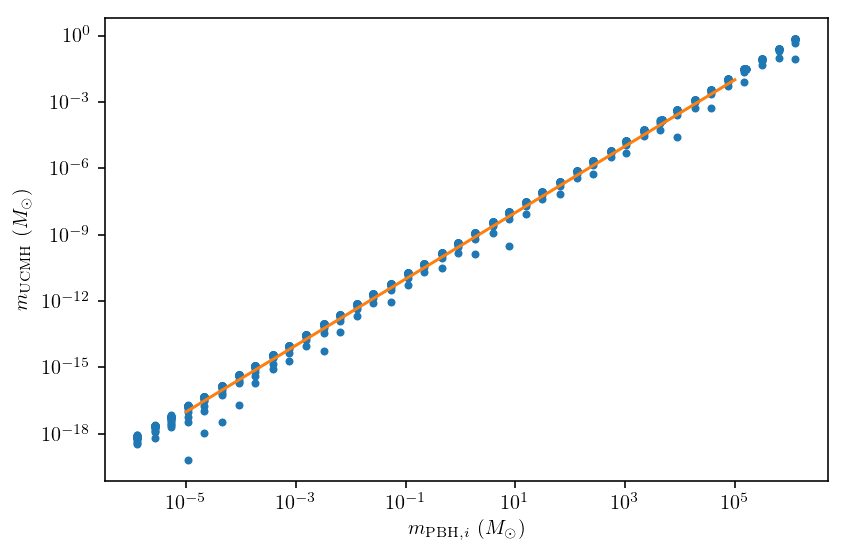

In [225]:
plt.plot(m_pbh_means.flatten(), m_ucmh_means.flatten(), '.')
plt.plot([1e-5, 1e5], [1e-17, 1e-2])

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_{{\rm PBH}, i}$ ($M_\odot$)")
plt.ylabel(r"$m_{\rm UCMH}$ ($M_\odot$)")

plt.tight_layout()
# plt.savefig("../figures/m_pbh_vs_m_ucmh.pdf")

Abundances

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


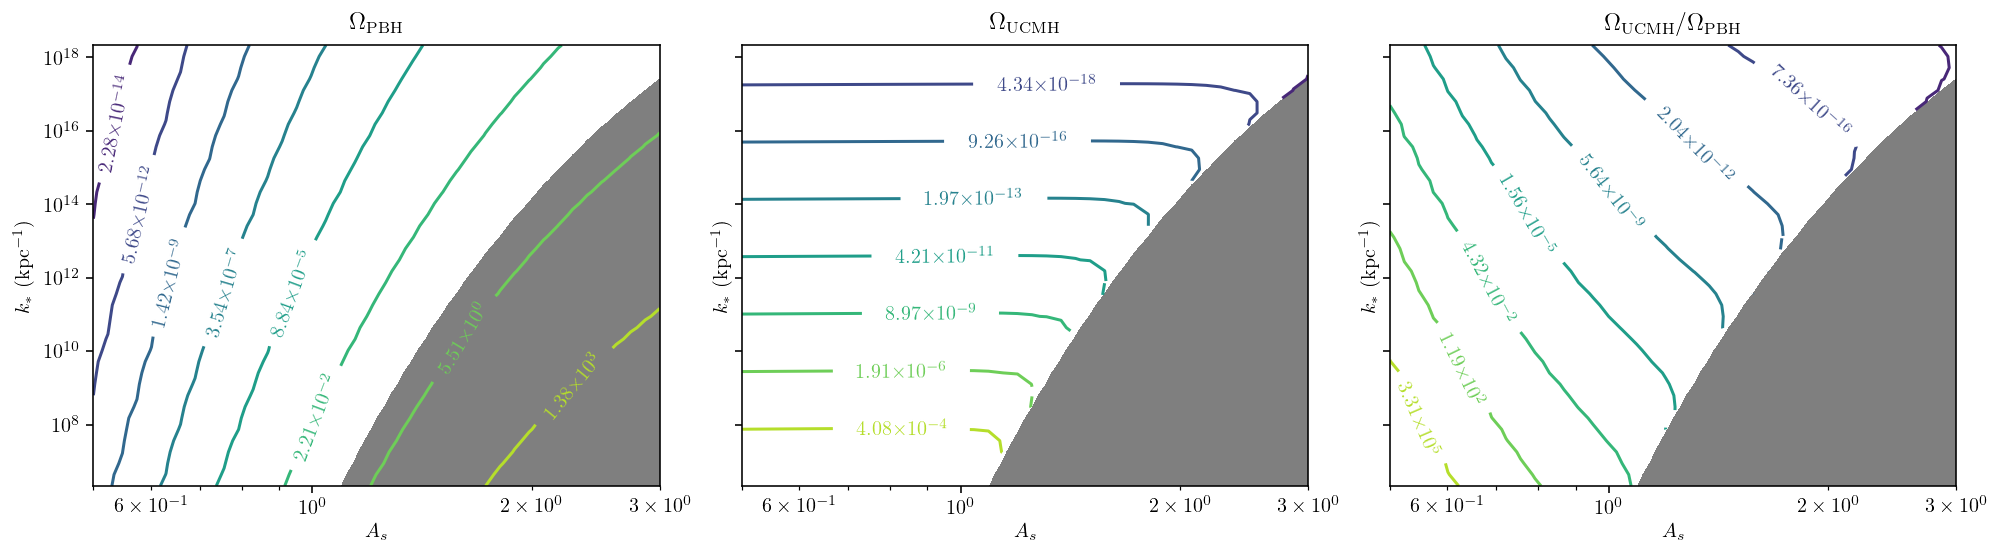

In [226]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14, 4))

for ax in axs:
    ax.set_xlabel(r"$A_s$")
    ax.set_ylabel(r"$k_*$ (kpc$^{-1}$)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.contourf(As_mg, ks_mg, f_pbhs, levels=[1., 1e99], colors=['k'], alpha=0.5)
    ax.contourf(As_mg, ks_mg, f_ucmhs, levels=[1., 1e99], colors=['k'], alpha=0.2)

for ax, f, title in zip(axs, [f_pbhs, f_ucmhs], ["PBH", "UCMH"]):
    sci_contours(As_mg, ks_mg, f, ax)
    ax.set_title(r"$\Omega_{\rm " + title + r"}$")

ax = axs[2]
ax.set_title(r"$\Omega_{\rm UCMH} / \Omega_{\rm PBH}$")
sci_contours(As_mg, ks_mg, f_ucmhs / f_pbhs, ax)

fig.tight_layout()
fig.savefig("../figures/abundances.pdf")

In [227]:
os.system("say 'Done'")

0

## Sanity checks

/Users/acoogan/Dropbox/Physics/Black holes/python/pyverse.py:141: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * erfc(delta_c / (np.sqrt(2) * sigma))
/Users/acoogan/Dropbox/Physics/Black holes/python/pyverse.py:158: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * (erfc(delta_min / (np.sqrt(2) * sigma)) -
/Users/acoogan/Dropbox/Physics/Black holes/python/pyverse.py:159: RuntimeWarning: divide by zero encountered in true_divide
  erfc(delta_max / (np.sqrt(2) * sigma)))


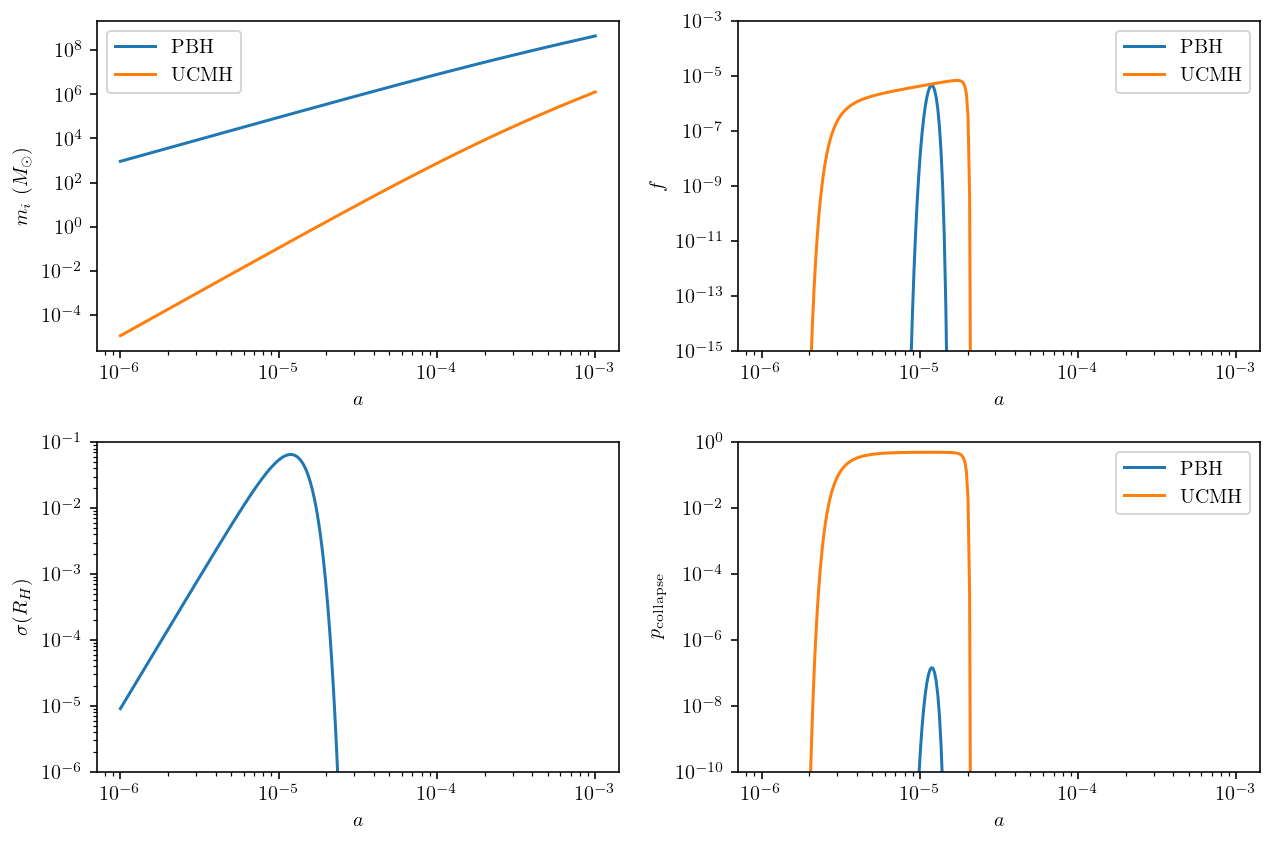

In [3]:
plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
plt.loglog(a_vals, m_pbhs, label="PBH")
plt.loglog(a_vals, m_ucmh_is, label="UCMH")
plt.legend()
plt.xlabel(r"$a$")
plt.ylabel(r"$m_i$ ($M_\odot$)")

plt.subplot(2, 2, 2)
plt.loglog(a_vals, df_dm_pbhs, label="PBH")
plt.loglog(a_vals, df_dm_ucmhs, label="UCMH")
plt.legend()
plt.xlabel(r"$a$")
plt.ylabel(r"$f$")
plt.ylim(1e-15, 1e-3)

plt.subplot(2, 2, 3)
plt.loglog(a_vals, sigma_spike(r_hor_phys(a_vals), As, ks))
plt.ylim(1e-6, 1e-1)
plt.xlabel(r"$a$")
plt.ylabel(r"$\sigma(R_H)$")

plt.subplot(2, 2, 4)
plt.loglog(a_vals, beta_pbh(a_vals), label="PBH")
plt.loglog(a_vals, beta_ucmh(a_vals), label="UCMH")
plt.legend()
plt.xlabel(r"$a$")
plt.ylabel(r"$p_{\rm collapse}$")
plt.ylim(1e-10, 1e0)

plt.tight_layout()
plt.savefig("../figures/other_info_As_1.56_as_1e-5.pdf")